In [1]:
import pygmt
import pickle
import imageio
import numpy as np
import xarray as xr

from shapely.ops import cascaded_union, polygonize
import shapely.geometry as geometry
from scipy.spatial import Delaunay
import numpy as np
import math

from descartes import PolygonPatch

import cartopy.crs as ccrs
from shapely.geometry import Point, Polygon

import matplotlib
import matplotlib.pyplot as plt

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%matplotlib inline

# River characteristics

> This notebook requires the dataset produced in notebook `4-basinMorpho`

In [4]:
step = 0

# Define output folder name for the simulation
out_path = 'export/unconstrained/'

dataset = xr.open_dataset(out_path+'data'+str(step)+'Ma.nc')
region = [-72,-42,-40,-12]

We clip the global dataset to a particular region of interest

In [4]:
mask_lon = (dataset.longitude >= region[0]) & (dataset.longitude <= region[1])
mask_lat = (dataset.latitude >= region[2]) & (dataset.latitude <= region[3])
clipds = dataset.where(mask_lon & mask_lat, drop=True)

Extract the number of unique basin indices in the clipped dataset

In [5]:
localbasins = clipds.basinID.values.astype(int)
uids = np.unique(localbasins)
localBasinNb = len(uids)
nids = np.arange(len(uids))

Replace basin indices with rearranged incremental indices for the region

In [6]:
mapIDs = np.zeros(localbasins.max()+1, dtype=int) 
mapIDs[uids] = nids
basinIDs = mapIDs[localbasins.flatten()].reshape(localbasins.shape)

Let's save the rearranged basin IDs in a new xarray dataframe

In [7]:
dsBasin = xr.DataArray(
    data=basinIDs.astype(float),
    dims=["latitude", "longitude"],
    coords={
        "lat": clipds.latitude,
        "lon": clipds.longitude,
    },
)
ds_masked = dsBasin.where(dsBasin != 0.) 
clipds["newBasin"]=(['latitude', 'longitude'],  ds_masked.values)
print(localBasinNb)

689


Now let's find the catchment ID corresponding to a specific coordinate:

In [8]:
nearest_point = clipds.sel(latitude=-25, longitude=-60, method="nearest")

We now extract the basin coordinates:

In [9]:
clipds2 = clipds.where(clipds.newBasin==nearest_point.newBasin.values)

## Create a shapefile from catchment points

Extract catchment coordinates

In [10]:
da_stacked = clipds2.basinID.stack(x=['latitude','longitude'])
da_stacked = da_stacked[da_stacked.notnull()]
lonlat = np.zeros((len(da_stacked),2))
lonlat[:,0] = da_stacked[da_stacked.notnull()].longitude.values
lonlat[:,1] = da_stacked[da_stacked.notnull()].latitude.values

We will now define the concave hull that contains the basin coordinates

In [11]:
def plot_polygon(polygon):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    margin = .3

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    
    return fig

def alpha_shape(coords, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
    return cascaded_union(triangles), edge_points

The value of `alpha` can be change to fit with basin coordinates

In [12]:
alpha = .9
concave_hull, edge_points = alpha_shape(lonlat, alpha=alpha)

# plot_polygon(concave_hull.buffer(0.1))
# _ = plt.plot(lonlat[:,0],lonlat[:,1],'o', color='#f16824')

/var/folders/px/dgn5m62n7bjbrc1d3cplcv7m0000gn/T/ipykernel_85368/2856282882.py:32: RuntimeWarning: divide by zero encountered in true_divide
  circums = a * b * c / (4.0 * areas)


We will now load the data saved from our previous notebook that has the main trunks of the river network from our basin (obtained using `pyshed`).

In [13]:
with open('branchesLonLat.data', 'rb') as filehandle:
    # read the data as binary data stream
    branch = pickle.load(filehandle)

Let's plot the dataset on a map:

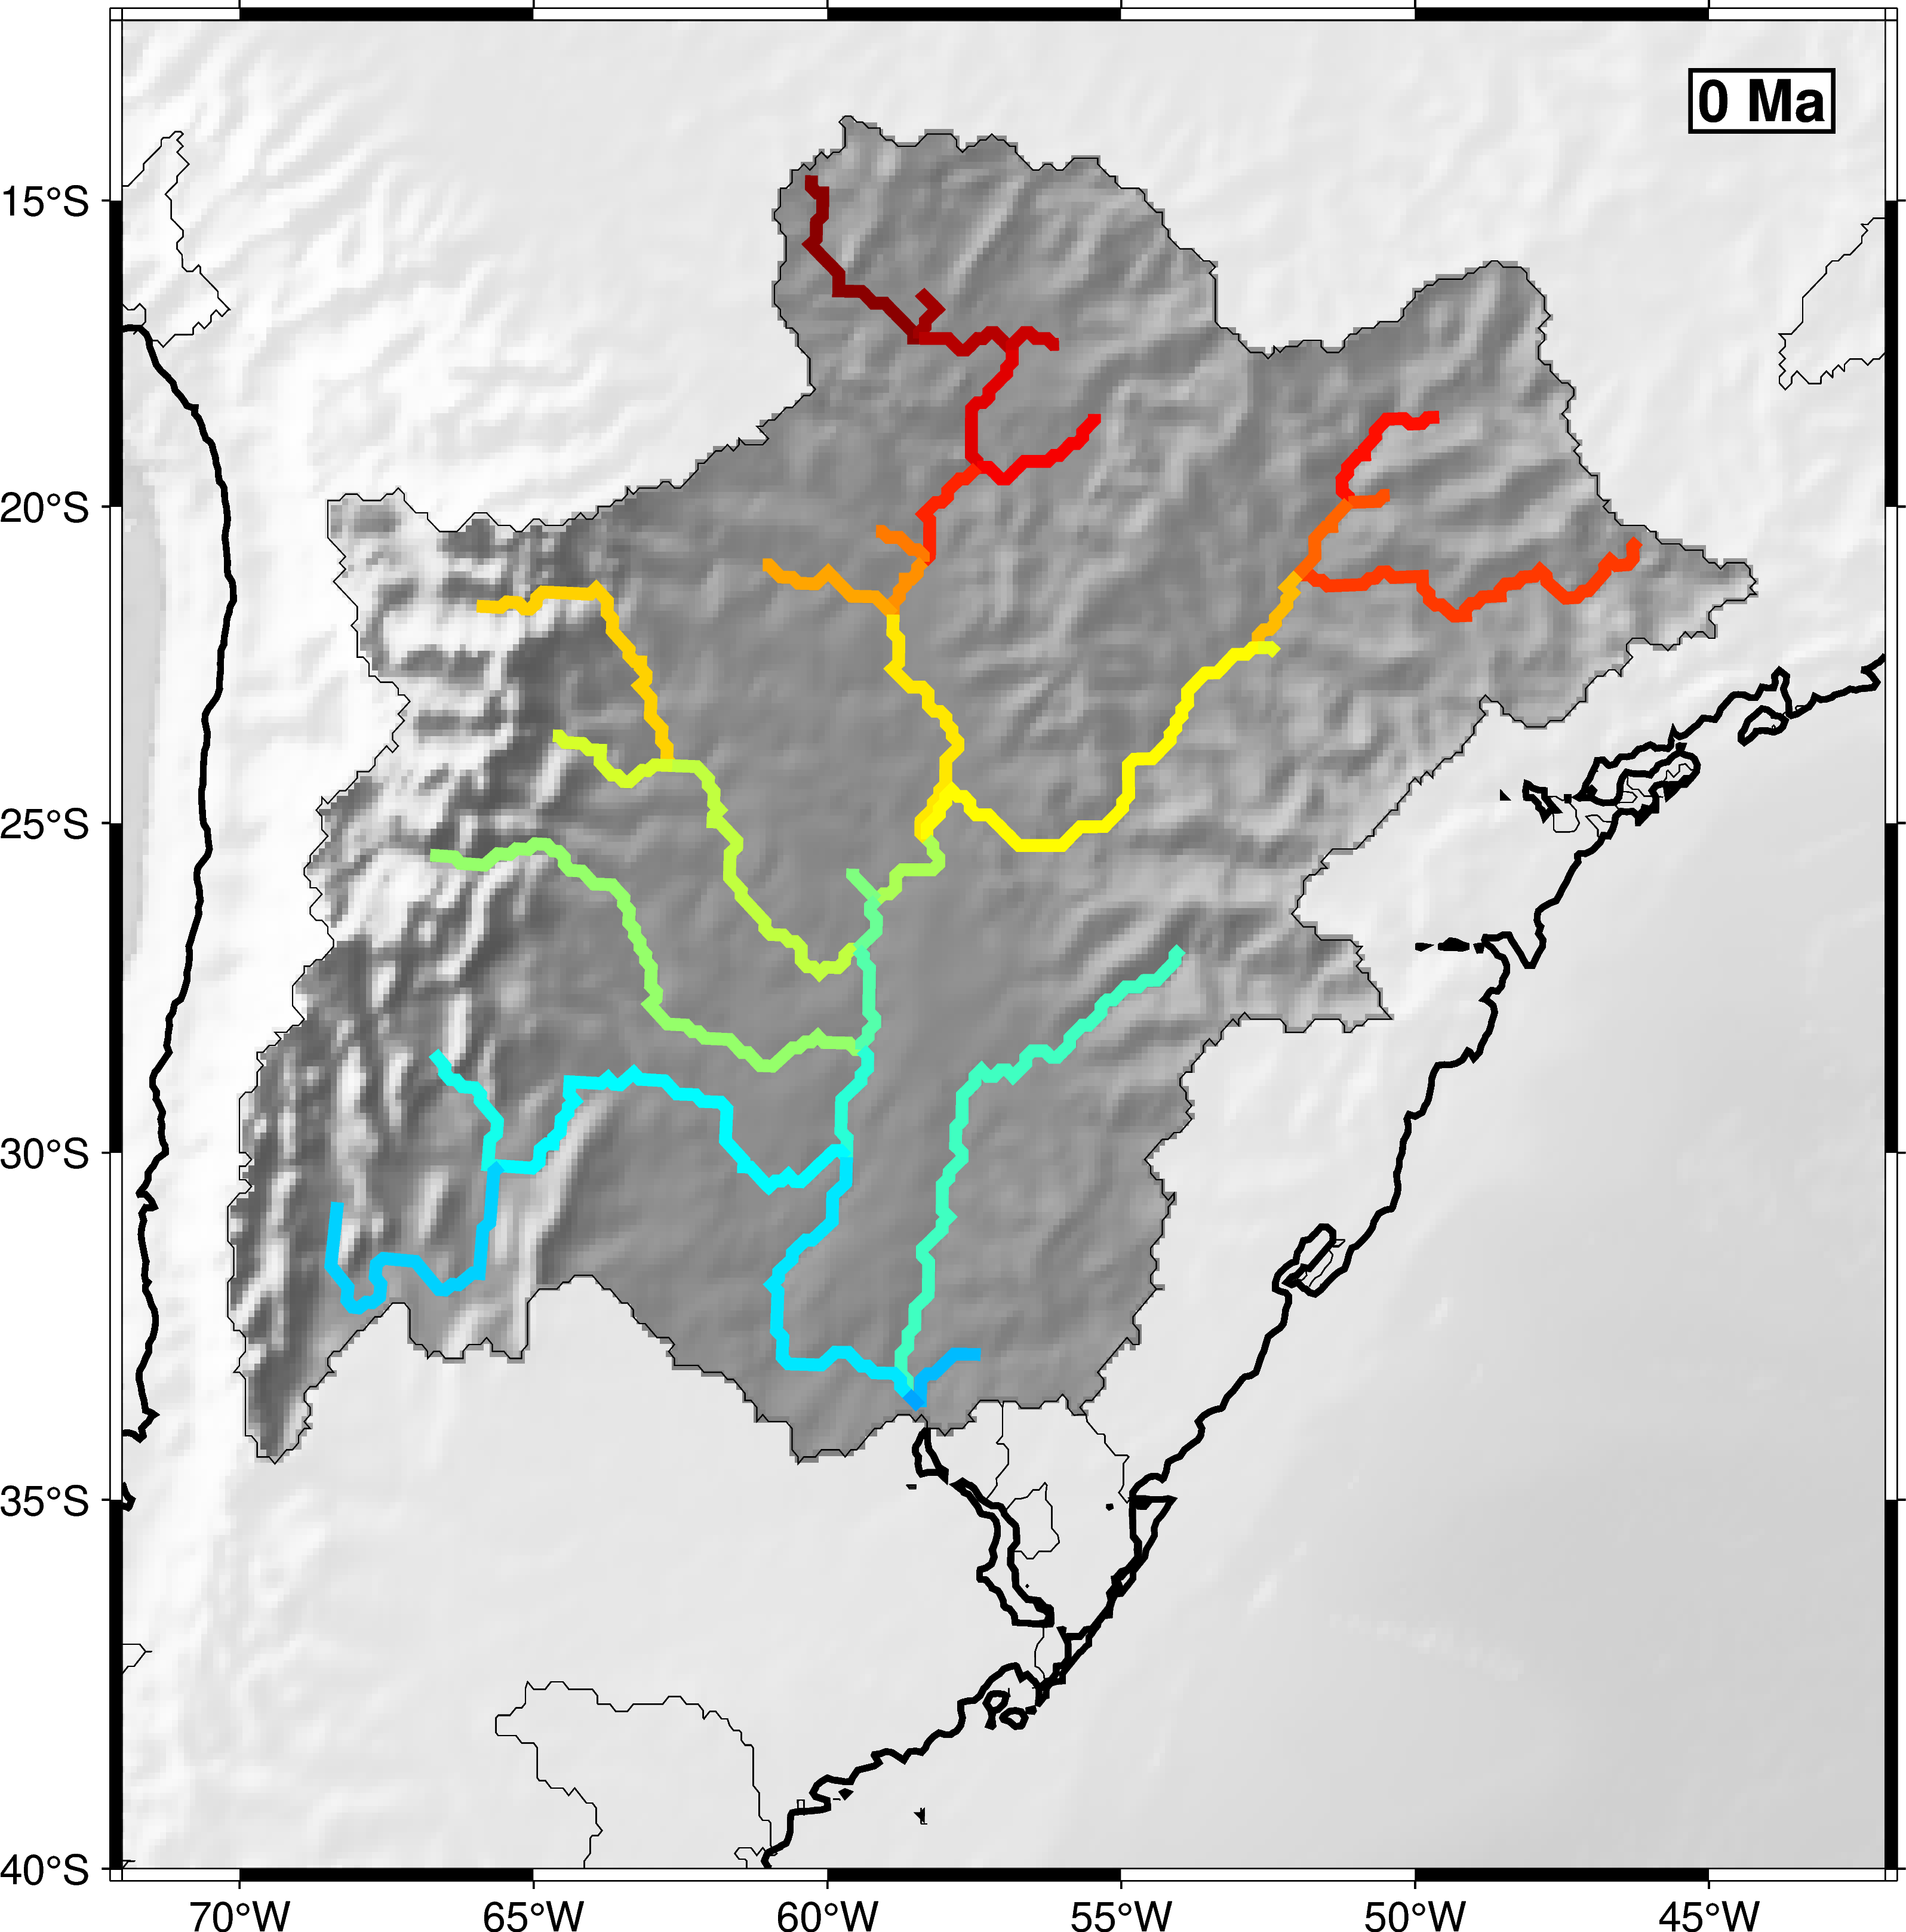

In [15]:
fig = pygmt.Figure()

# Plotting elevation
with pygmt.config(FONT='10p,Helvetica,black'):
    
#     pygmt.makecpt(cmap="geo", series=[-6000, 6000])
    pygmt.makecpt(cmap="gray", series=[-6000, 6000])
    
    fig.basemap(region=region, projection='M15c', frame='a')
    
    fig.grdimage(clipds.elevation, 
                 shading=True, 
                 frame=False,
                 nan_transparent=True,
                 transparency=80,
                )
    
    fig.grdimage(clipds2.elevation, 
                 shading=True, 
                 frame=False,
                 nan_transparent=True,
                 transparency=0,
                 
                )
    
    pygmt.makecpt(cmap="jet", 
                  reverse=True,
                  series=[0, 46, 1], 
                  color_model="+c0-46")
    k = 0
    for brch in branch['features']:
        line = np.asarray(brch['geometry']['coordinates'])
        newline = []
        for p in range(len(line[:,0])):
            p1 = Point(line[p, 1], line[p, 0])
            if p1.within(concave_hull.buffer(-0.2)):
                newline.append([line[p, 1], line[p, 0]])
        ll = np.asarray(newline)
        if len(ll)>1:
            fig.plot(x=ll[:, 0], y=ll[:, 1], 
                     pen="3p,purple", 
                     cmap=True, zvalue=k, 
                     transparency="0")
            k += 1
        
    # Add contour
    fig.grdcontour(
        interval=0.1,
        grid=clipds.elevation,
        limit=[-0.1, 0.1],
        pen='1.5p'
    )

# At time step
fig.text(text=str(step)+" Ma", position="TR", 
         fill='white', pen='1p', offset='-0.5',
         font="14p,Helvetica-Bold,black",)

# Add contour
fig.grdcontour(
    interval=1,
    grid=clipds.newBasin,
    region=region,
    projection='M15c',
    limit=[582, 583],
    pen = '0.25p'
)

# name = 'catchment'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)

fig.show(dpi=500, width=500)

# Plotting the river profiles

Again this is done by using the second saved dataset from the previous notebook.

In [16]:
with open('profile.data', 'rb') as filehandle:
    # read the data as binary data stream
    profile = pickle.load(filehandle)

We now work on the dataset to find the river points part of the basin ID

In [17]:
ndf = []
for p in range(len(profile)):
    df = profile[p]
    ins = np.zeros(len(df))
    for k in range(len(df)):
        p1 = Point(df.lon[k], df.lat[k]) 
        if p1.within(concave_hull.buffer(-0.2)):
            ins[k] = 1
    df['in'] = ins
    newdf = df[df['in'] > 0].reset_index(drop=True)
    newdf.drop('in', axis=1, inplace=True)
    ndf.append(newdf)

We combine a list of daframe for each trunk:

In [18]:
combdf = []

for p in range(len(ndf)):
    df = ndf[p]

    z = np.zeros(len(df))
    ed = np.zeros(len(df))
    fa = np.zeros(len(df))
    sl = np.zeros(len(df))
    up = np.zeros(len(df))

    for k in range(len(df)):
        nlon = df['lon'][k]
        nlat = df['lat'][k]
        nearest_point = clipds.sel(latitude=nlat, longitude=nlon, method="nearest")
        z[k] = nearest_point.elevation.values
        ed[k] = nearest_point.erodep.values
        fa[k] = nearest_point.fillDischarge.values
        sl[k] = nearest_point.sedimentLoad.values
        up[k] = nearest_point.uplift.values
    df['nelev'] = z    
    df['ed'] = ed   
    df['fa'] = fa   
    df['sedload'] = sl   
    df['up'] = up   
    combdf.append(df)

### Plotting using matplotlib

In [23]:
import matplotlib.pyplot as plt
import cmocean as cmo

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Profile elevation

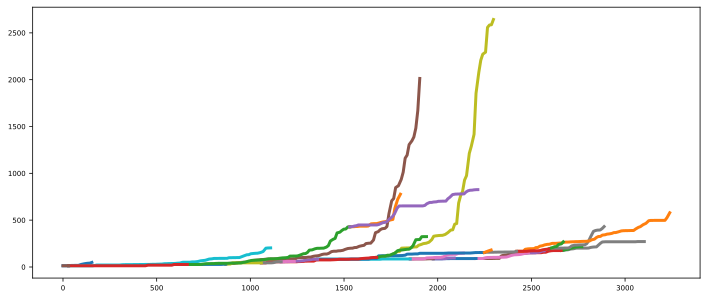

In [24]:
plt.figure(figsize=(12,5))

ax = plt.gca()

for branch in range(0,len(combdf)):
    distance = np.asarray(combdf[branch].dist)
    elev = np.asarray(combdf[branch].elev)

    plt.plot(distance/1.e3, elev, lw=3)
    
# plt.savefig('profiles.png', bbox_inches='tight', dpi=500)
plt.show()

Erosion/deposition along profile

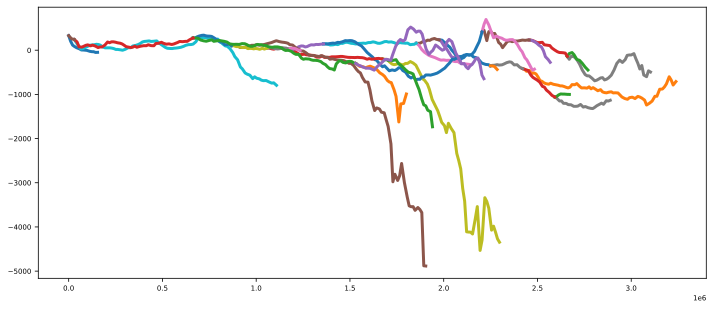

In [26]:
plt.figure(figsize=(12,5))
ax = plt.gca()
for branch in range(0,len(combdf)):
    distance = np.asarray(combdf[branch].dist)
    elev = np.asarray(combdf[branch].ed)

    plt.plot(distance, elev, lw=3)

Uplift component along profile

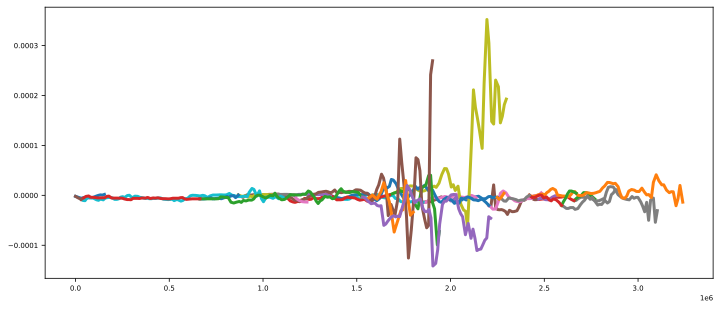

In [27]:
plt.figure(figsize=(12,5))
ax = plt.gca()
for branch in range(0,len(combdf)):
    distance = np.asarray(combdf[branch].dist)
    elev = np.asarray(combdf[branch].up)

    plt.plot(distance, elev, lw=3)

### Plotting using pygmt

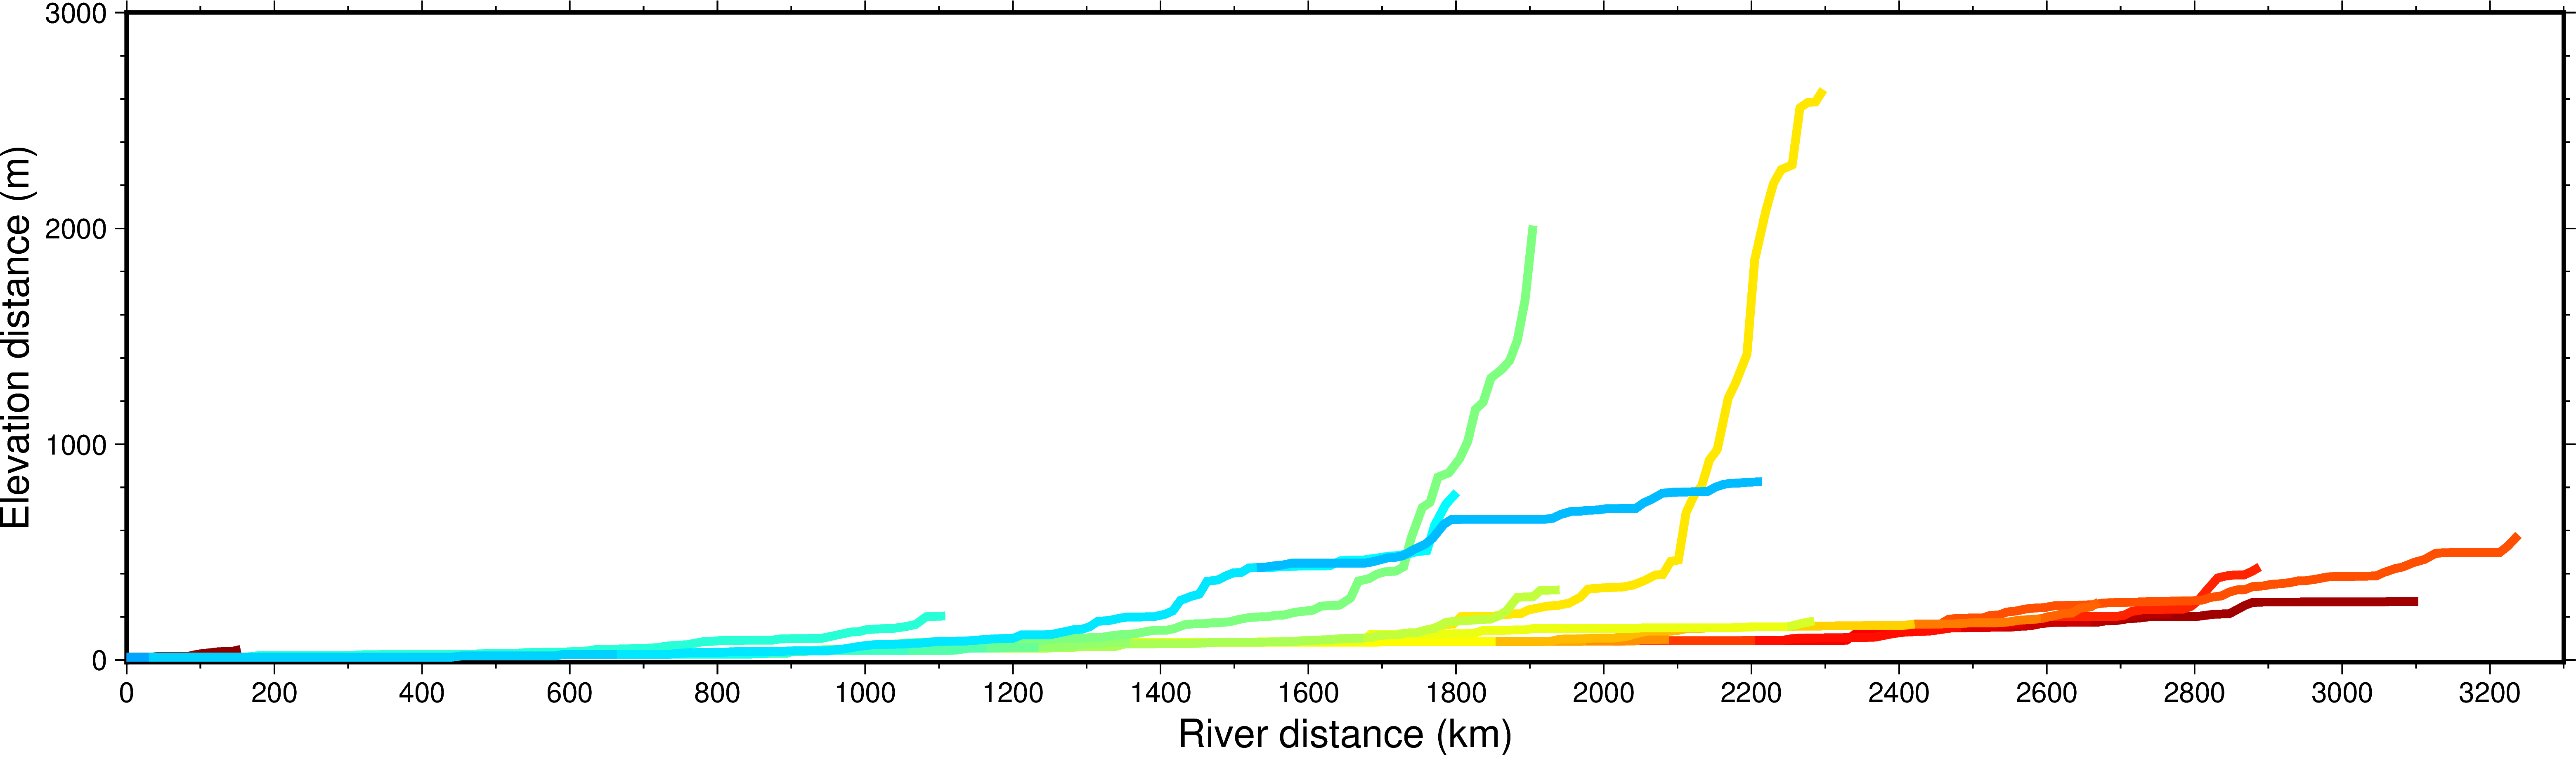

In [21]:
fig = pygmt.Figure()

with fig.subplot(nrows=1, ncols=1, figsize=("30c", "8c"), frame="lrtb"):
    with fig.set_panel(panel=0):  # sets the current panel
        
        fig.basemap(frame=["WSne", 'xaf+l"River distance (km)"', 'yaf+l"Elevation distance (m)"'], 
                    region=[0, 3300, -10, 3000])
        pygmt.makecpt(cmap="jet", 
                          reverse=True,
                          series=[0, 46, 1], 
                          color_model="+c0-46")

        p = 0
        for k in range(0,len(combdf)):
            dist = np.asarray(combdf[k].dist)/1.e3
            elev = np.asarray(combdf[k].elev)
            if len(dist)>0:    
                fig.plot(x=dist, y=elev, 
                         pen="3p,purple", 
                         cmap=True, zvalue=p, 
                         transparency="0")
                p += 1  

# name = 'profile'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)
fig.show(dpi=500, width=1000)

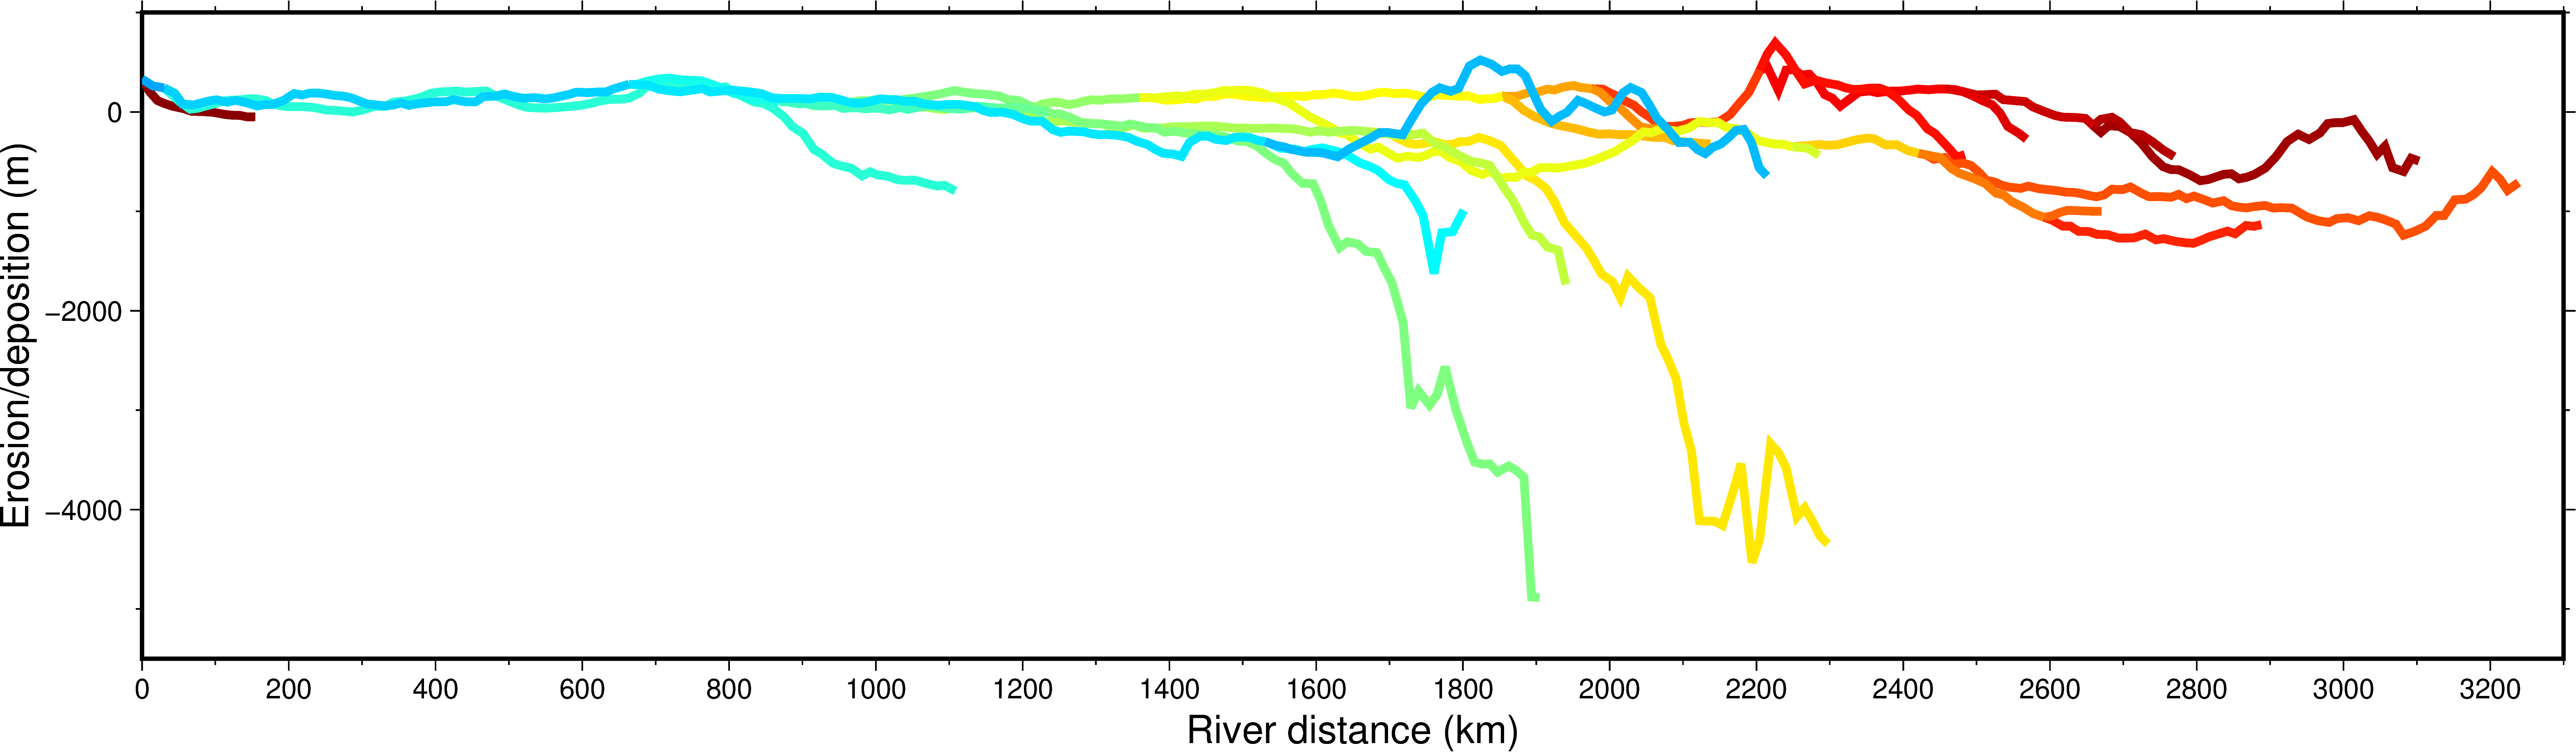

In [22]:
fig = pygmt.Figure()

with fig.subplot(nrows=1, ncols=1, figsize=("30c", "8c"), frame="lrtb"):
    with fig.set_panel(panel=0):  # sets the current panel
        
        fig.basemap(frame=["WSne", 'xaf+l"River distance (km)"', 'yaf+l"Erosion/deposition (m)"'], 
                    region=[0, 3300, -5500, 1000])
        pygmt.makecpt(cmap="jet", 
                          reverse=True,
                          series=[0, 46, 1], 
                          color_model="+c0-46")

        p = 0
        for k in range(0,len(combdf)):
            dist = np.asarray(combdf[k].dist)/1.e3
            elev = np.asarray(combdf[k].ed)
            if len(dist)>0:    
                fig.plot(x=dist, y=elev, 
                         pen="3p,purple", 
                         cmap=True, zvalue=p, 
                         transparency="0")
                p += 1  

# name = 'edprofile'+str(step)+'Ma.png'
# fig.savefig(fname=name,dpi=500)
fig.show(dpi=500, width=1000)